In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from math import pi

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, brentq, fsolve
from scipy.integrate import quad, simpson, solve_ivp
from scipy.special import zeta

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['mathtext.fontset'] = 'stix'#['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
# font = {'family': 'Times New Roman',
#         #'color':  'black',
#         'weight': 'normal',
#         'size': 14,
#         }

In [2]:
# aesthetic definitions for the plots
# font = {'size'   : 16, 'family':'STIXGeneral'}
# axislabelfontsize='large'
# matplotlib.rc('font', **font)
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
# plt.rcParams["figure.figsize"] = [8.0,6.0]

# %config InlineBackend.figure_format = "retina"
# plt.rcParams['figure.figsize'] = (13, 8)
# plt.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
# plt.rcParams['font.serif'] = ['New Times Roman']
# # plt.rc('text', usetex=True)

# 0. Preamble

## 0.1 Definitions, Constants, and Parameters

Natural Units:

In [3]:
eV = 1.e-9
keV = 1.e-6
MeV = 1.e-3
GeV = 1.
TeV = 1.e3

SI Units (and others):

In [4]:
Kelvin = (8.61734231196981e-5)*eV
sec = (1.519268e21)/MeV
yr = (3.15576e7)*sec
gr = (5.609589e23)*GeV
mtr = (5.067731e15)/GeV
km = 1000*mtr
cm = 0.01*mtr
Mpc = (3.08567758128e19)*km

Useful cosmological parameters and constants:

In [ ]:
Mpl = (1.22091e19) * GeV
mpl = Mpl/np.sqrt(8.*pi)
MGUT = 1.e15 * GeV

In [ ]:
h = 0.6766
rho_crit = 3.* mpl**2 * (100.*h * km/sec / Mpc)**2
H0 = np.sqrt(rho_crit / (3. * mpl**2))

In [7]:
T_g0 = 2.7255*Kelvin
gs0 = 3.94
ge0 = 3.38
ge_1nu = 2.*(7./8.)*(4./11.)**(4./3.)
gSM = 106.75

ncoeff = zeta(3.)/(pi**2)
ffn = 3./4.

rho_coeff = (pi**2.)/ 30.
ffrho = 7./8.

scoeff = 2.*pi**2 / 45.
ffs = ffrho

s0tot = gs0*scoeff*T_g0**3.
nsRatio = ncoeff/scoeff

In [8]:
Omega_b = 0.02242/h**2
Omega_dm = 0.11933/h**2
Omega_m = Omega_b + Omega_dm

Useful particle physics constants and parameters:

In [9]:
vEW = 246.*GeV
mh = 125.25*GeV
mZ = 91.19*GeV
mW = 80.377*GeV

mu, md, ms, mc, mb, mt = 2.16*MeV, 4.67*MeV, 93.4*MeV, 1.27*GeV, 4.18*GeV, 172.69*GeV

mp = 938.2720813*MeV
mn = 939.5654133*MeV
mpi = 134.9768*MeV
fpi = 92.*MeV
me = 0.51099895*MeV

zud = mu/md
zp = zud/(1 + zud)**2

Tcrit = 150.*MeV

alpha_em = 0.00729735253

## 0.2 Important Functions

### 0.2.1 $\rho_{\rm rad}(g_{*e}, T)$, and $H(\rho)$

In [ ]:
def rho_rad(gse, Temp):
    """
    rho_rad : radiation energy density [GeV^4].

    Parameters:
    gse : relativistic d.o.f. in entropy
    Temp : temperature [GeV]

    Returns:
    rho_rad [GeV^4]
    """

    return rho_coeff * gse * Temp**4

def Hubble(rho):
    """
    Hubble : Hubble expansion rate [GeV].

    Parameters:
    rho : energy density [GeV^4]

    Returns:
    Hubble [GeV]
    """

    return np.sqrt( rho/ (3. * mpl**2.))

### 0.2.2 $g_{*s}(T)$

Obtaining $\ g_{*s}(T \text{ [GeV]})$ table from data file:

In [22]:
gs_data = np.genfromtxt('./data/entropy_dof.csv', delimiter=',')
gs_data

array([[9.85024245e-06, 3.94000000e+00],
       [1.29241610e-05, 3.94000000e+00],
       [1.56304387e-05, 3.94000000e+00],
       [2.03233248e-05, 3.94000000e+00],
       [2.59510332e-05, 3.94000000e+00],
       [3.46715923e-05, 3.95000000e+00],
       [4.42724629e-05, 3.95263399e+00],
       [5.70460300e-05, 4.07754518e+00],
       [7.28425803e-05, 4.26918854e+00],
       [9.05210686e-05, 4.56352053e+00],
       [1.08097063e-04, 4.95022239e+00],
       [1.28722620e-04, 5.40810431e+00],
       [1.44291199e-04, 6.05839201e+00],
       [1.68214265e-04, 6.68651100e+00],
       [2.02620854e-04, 7.45826899e+00],
       [2.40651877e-04, 8.03923183e+00],
       [2.88420558e-04, 8.70581383e+00],
       [3.51987198e-04, 9.30226198e+00],
       [4.29563649e-04, 9.77626487e+00],
       [5.24237614e-04, 1.01301401e+01],
       [6.39777310e-04, 1.03829295e+01],
       [7.80781454e-04, 1.05521079e+01],
       [9.52862299e-04, 1.06635492e+01],
       [1.16286902e-03, 1.06894331e+01],
       [1.419160

Taking the $\log_{10}$ of the x-axis (i.e., the temperature):

In [23]:
gs_Lxydata = np.array([np.log10(gs_data[:,0]), gs_data[:,1]]).transpose()
gs_Lxydata

array([[-5.00655308e+00,  3.94000000e+00],
       [-4.88859764e+00,  3.94000000e+00],
       [-4.80602883e+00,  3.94000000e+00],
       [-4.69200524e+00,  3.94000000e+00],
       [-4.58584535e+00,  3.94000000e+00],
       [-4.46002621e+00,  3.95000000e+00],
       [-4.35386632e+00,  3.95263399e+00],
       [-4.24377457e+00,  4.07754518e+00],
       [-4.13761468e+00,  4.26918854e+00],
       [-4.04325033e+00,  4.56352053e+00],
       [-3.96618611e+00,  4.95022239e+00],
       [-3.89034513e+00,  5.40810431e+00],
       [-3.84076016e+00,  6.05839201e+00],
       [-3.77413718e+00,  6.68651100e+00],
       [-3.69331586e+00,  7.45826899e+00],
       [-3.61861075e+00,  8.03923183e+00],
       [-3.53997379e+00,  8.70581383e+00],
       [-3.45347313e+00,  9.30226198e+00],
       [-3.36697248e+00,  9.77626487e+00],
       [-3.28047182e+00,  1.01301401e+01],
       [-3.19397117e+00,  1.03829295e+01],
       [-3.10747051e+00,  1.05521079e+01],
       [-3.02096986e+00,  1.06635492e+01],
       [-2.

Interpolating the resulting grid:

In [24]:
gs_fnLxy = interp1d(gs_Lxydata[:,0], gs_Lxydata[:,1], bounds_error=False)

Finally, defining the function $g_{*s}(T \, \text{[GeV]})$ for any temperature:

In [ ]:
def gs_fn(Temp):
    """
    gs_fn : function giving the relativistic d.o.f. in entropy.
    
    Parameters:
    Temp : temperature [GeV]

    Returns:
    gs_fn
    """

    Tarr = np.asarray(Temp)

    result = np.where(Tarr <= gs_data[0,0], gs0, np.where(Tarr <= gs_data[-1,0], gs_fnLxy(np.log10(Tarr)), gSM))
    
    if np.isscalar(Temp):
        return result.item()
    else:
        return result

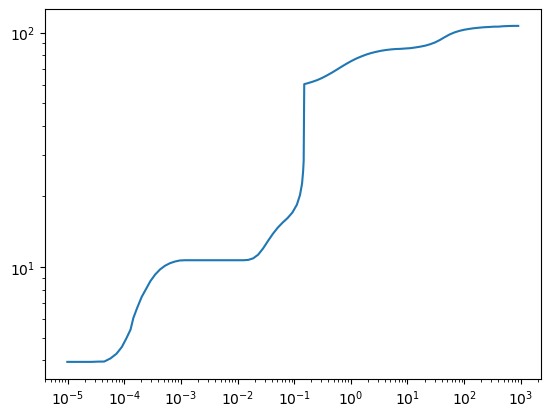

In [27]:
plt.loglog(gs_data[:,0], gs_data[:,1])

Defining $\frac{d \ln g_{*s}}{d \ln T}$:

In [28]:
Thi = 100.*TeV

# Temp_arr = np.logspace(np.log10(T_g0), np.log10(Thi), 10001)
Temp_arr = np.logspace(np.log10(eV), np.log10(Thi), 10001)
gs_arr = np.vectorize(gs_fn)(Temp_arr)

dLgdLT_arr = np.gradient(np.log(gs_arr), np.log(Temp_arr))

From entropy conservation ($S = g_{*s} T^3 a^3 = \text{const.}$) we get:

$\frac{d \ln a}{d \ln T} = -1 - \frac{1}{3} \frac{d \ln g_{*s}}{d \ln T}$

In [29]:
dLadLT_arr = -1. - (1./3.)*dLgdLT_arr

dLadLT_fn = interp1d(np.log(Temp_arr), dLadLT_arr, bounds_error=False)

(-13.0, 0.0)

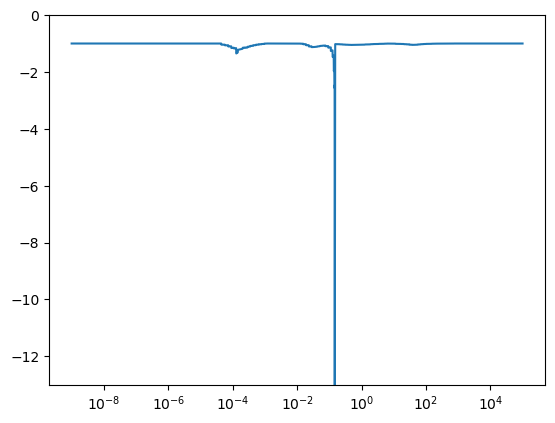

In [30]:
plt.plot(Temp_arr, dLadLT_arr)
plt.xscale('log')
plt.ylim(-13,0)

### 0.2.4 $t(T)$

Find the time as a function of the temperature: $\Delta t \equiv t - t_i = \int\limits_{\ln a_i}^{\ln a} \, d \ln a \, \frac{1}{H(T)} = \int\limits_{\ln T_i}^{\ln T} \, d \ln T \, \frac{d \ln a}{d \ln T} \frac{1}{H(T)}$

In [ ]:
def time_fn(Temp, Tini=Thi, limit=1000, epsabs=1.e-6, epsrel=1.e-4):
    """
    time_fn : age of the Universe [GeV^-1] and its absolute error for a given temperature, starting from a very high temperature.

    Parameters:
    Temp : temperature [GeV]
    Tini : initial (high) temperature [GeV] (default: Thi)
    limit : limit of integration steps (default: 1000)
    epsabs : absolute integration error tolerance (default: 1.e-6)
    epsrel : relative integration error tolerance (default: 1.e-4)

    Returns:
    (time [GeV^-1], abs_error(time) [GeV^-1])
    """

    def Hubble_rate(lnT): return Hubble(rho_rad(gs_fn(np.power(np.e, lnT)), np.power(np.e, lnT))) # Hubble expansion rate [GeV] as a function of ln(T)

    def integrand(lnT): return dLadLT_fn(lnT) / (Hubble_rate(lnT) * (GeV*sec)) # integrand [sec] as a function of ln(T)

    res, error = quad(lambda lnT: integrand(lnT), np.log(Tini), np.log(Temp), limit=limit, epsabs=epsabs, epsrel=epsrel) # integrating

    return res*(GeV*sec), error*(GeV*sec) # result in [GeV^-1]

Test: the Universe is about 1 sec old at 1 MeV:

In [78]:
print(((time_fn(MeV)))[0]/sec, ((time_fn(0.85*MeV)))[0]/sec)

0.7412059272518452 1.0301833296216591


In [79]:
time_fn(150*MeV)[0]/sec

1.3956701135419946e-05

In [80]:
time_arr = np.array([time_fn(T)[0] for T in Temp_arr]) # array of time [GeV]

Checking the earliest times (latest in the array):

In [81]:
time_arr[-3:]

array([461878.65234102, 230194.86831948,     -0.        ])

Correcting the earliest time to be positive:

In [82]:
time_arr[-1] = 0.

In [83]:
time_arr

array([1.85249480e+36, 1.84058974e+36, 1.82876119e+36, ...,
       4.61878652e+05, 2.30194868e+05, 0.00000000e+00])

### 0.2.5 $T(t)$:

Inverting $t(T)$:

In [84]:
new_tarr = (time_arr[::-1])[1:] # reversing the entries (i.e., written them in increasing time), and dropping the first one (for which t=0)
new_Tarr = (Temp_arr[::-1])[1:]

LTLt_fn = interp1d(np.log10(new_tarr), np.log10(new_Tarr), bounds_error=False) # interpolating T(t) in log-space

In [ ]:
def T_fn(t):
    """
    T_fn : Temperature [GeV] as a function of the age of the Universe t [GeV^-1].

    Parameters:
    t : time/age of the Universe [GeV^-1]

    Returns:
    T_fn [GeV]
    """

    tarr = np.asarray(t)

    last_t = new_tarr[-1]

    res = np.where(tarr > last_t, (10.**LTLt_fn(np.log10(last_t)))*(tarr/last_t)**(-1/2), 10.**LTLt_fn(np.log10(tarr)))

    return res.item() if np.isscalar(t) else res

In [86]:
T_fn(sec)/MeV

0.862523192154525

The critical time $t_c$ at which $T=T_c$

In [87]:
tcrit = time_fn(Tcrit)[0]

print(tcrit, "GeV =", tcrit/sec, "sec")

2.120396942060719e+19 GeV = 1.3956701135419946e-05 sec


Dimensionless $\hat{T}(\hat{t}) \equiv T(\hat{t} \cdot t_c)/T_c$

In [ ]:
def T_hat_fn(t_hat):
    """
    T_hat_fn : Temperature in units of Tcrit [dimless] as a function of time t in units of tcrit [dimless].

    Parameters:
    t_hat : time in units of tcrit [dimless]

    Returns:
    T_hat_fn [dimless]
    """

    return T_fn(t_hat*tcrit)/T_fn(tcrit)

In [89]:
time_arr/(time_fn(Tcrit)[0])

array([8.73654719e+16, 8.68040178e+16, 8.62461718e+16, ...,
       2.17826504e-14, 1.08562158e-14, 0.00000000e+00])

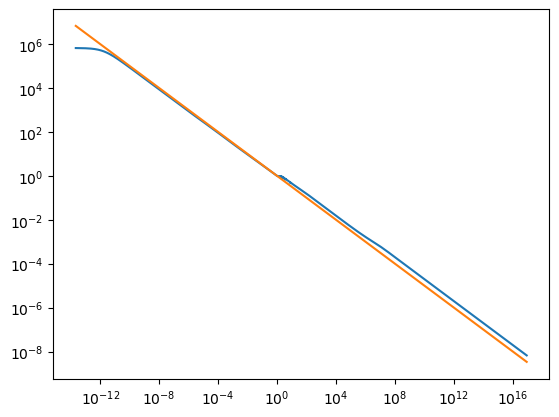

In [105]:
plt.loglog(new_tarr[1:]/tcrit, new_Tarr[1:]/Tcrit)
plt.loglog(new_tarr[1:]/tcrit, (new_tarr[1:]/tcrit)**(-1/2))

### 0.2.6 $H(t)$

In [106]:
def Hubt(t):
    """
    Hubt : Hubble expansion rate [GeV].

    Parameters:
    t : time [GeV^-1]

    Returns:
    Hubt [GeV]
    """

    gs_t = gs_fn(T_fn(t)) # rel. d.o.f. in entropy at the time
    T_t = T_fn(t) # temperature at the time [GeV]

    rho_r_t = rho_rad(gs_t, T_t) # radiation energy density at the time [GeV^4]
    hub_t = Hubble(rho_r_t) # Hubble rate at the time [GeV^-1]

    return hub_t

### 0.2.7 $a(t)$

In [107]:
def scale_factor(t):
    """
    scale_factor : scale factor of the Universe [dimless].
     
    Parameters:
    t : time [GeV^-1]

    Returns:
    scale_factor [dimless]
    """

    S0 = gs0 * T_g0**3 # total entropy today

    T_t = T_fn(t) # temperature at the time [GeV]
    gs_t = gs_fn(T_t) # rel. d.o.f. in entropy at the time
    
    a_t = np.power(S0/(gs_t * T_t**3), 1/3)

    return a_t

In [108]:
scale_factor(new_tarr[-1]*10000000)

0.7427104446616855

# 1. Axion Physics

## 1.1 Temperature dependence

Interpolation function of the temperature-dependence of the topological suceptibility, $F(T)$, and its derivative $F'(T)$

In [109]:
def FTemp(T, p=12, small=1.e-6):
    """
    FTemp : ad-hoc interpolation function of the temperature dependence of the topological susceptibility, F(T) [dimless].

    Parameters:
    T : temperature [GeV]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    FTemp [dimless]
    """

    x = T/Tcrit # ratio of temperature to critical temperature

    xarr = np.asarray(x) # turning argument into array

    func = 1./np.power(1 + np.power(xarr, 8*p), 1./p) # interpolating function

    target = np.where(xarr > 1, 0, 1) # asymptotic target value
    diff = np.abs(target - func) # difference between interpolating function and asymptotic value

    res = np.where(diff < small, target, func)


    return res.item() if np.isscalar(x) else res

/tmp/ipykernel_22832/96244947.py:18: RuntimeWarning: overflow encountered in power
  func = 1./np.power(1 + np.power(xarr, 8*p), 1./p) # interpolating function


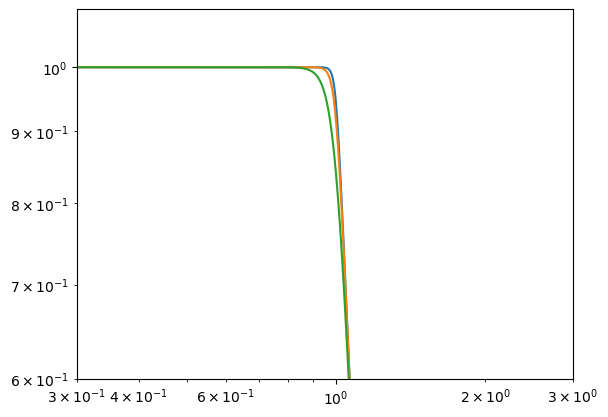

In [110]:
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr))
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr, 8))
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr, 4))

plt.xlim(0.3, 3)
plt.ylim(0.6,1.1);

In [111]:
def dFTdT(T, p=12, small=1.e-6):
    """
    dFTdT : Derivative F'(T) [GeV^-1] of F(T) w.r.t. temperature.

    Parameters:
    T : temperature [GeV]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    dFTdT [GeV^-1]
    """

    x = T/Tcrit # ratio of temperature to critical temperature

    FT = FTemp(T, p, small=small)

    return -8.*np.power(FT*np.power(x,(8.*p)/(1.+p)), 1.+p)/T

## 1.2 Canonical Axion

Oscillatory part of the axion potential: $\sqrt{1 + 2z' \left( \cos(\theta) - 1 \right)}$,

where $z' \equiv z/(1+z)^2$.

In [112]:
def chpt_fn(theta):
    """
    chpt_fn : Dependence of the topological susceptibility on the axion angle, obtained from chiral perturbation theory.

    Parameters:
    theta : axion angle [radians]

    Returns:
    chpt_fn [dimless]
    """
    
    return np.sqrt(1. + 2.*zp*( np.cos(theta) - 1. ))

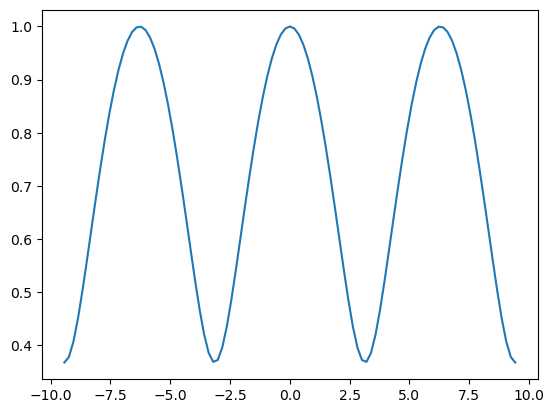

In [113]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, chpt_fn(tharr))

del tharr

Axion potential from QCD:

$V_{\rm QCD}(\theta) = - m_\pi^2 f_\pi^2 \, \sqrt{1 + 2z' \left( \cos(\theta) - 1 \right)}$

In [114]:
def Va_QCD(theta, cancel_cc=True):
    """
    Va_QCD : axion potential [GeV^4] from QCD, according to leading order in chiral perturbation theory.

    Parameters:
    theta : axion angle [radians]
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_QCD [GeV^4]
    """
    
    pref = mpi**2 * fpi**2
    osc = chpt_fn(theta)

    v = -pref*osc

    if cancel_cc == True:
        v -= -pref
    
    return v

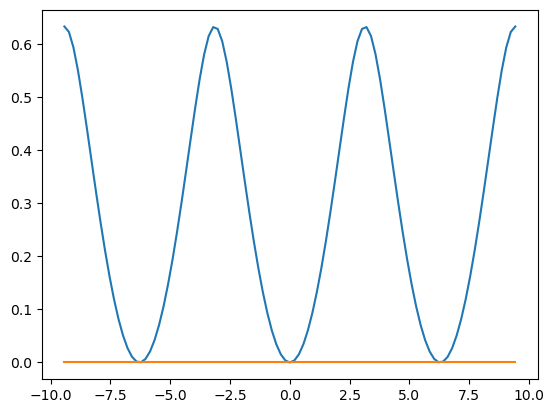

In [115]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, Va_QCD(tharr, True)/(mpi**2 * fpi**2))
plt.plot(tharr, np.zeros_like(tharr))

del tharr

Field-derivative:

$V'(\theta) = z' \, m_\pi^2 f_\pi^2 \, \frac{\sin(\theta)}{\sqrt{1 + 2z' \left( \cos(\theta) - 1 \right)}}$

In [116]:
def Va_QCD_prime(theta):
    """
    Va_QCD_prime : the field derivative of the axion QCD potential [GeV^4].

    Parameters:
    theta : axion field

    Returns:
    Va_QCD_prime [GeV^4]
    """

    pref = mpi**2 * fpi**2
    ma2fa2 = zp*pref
    
    num = ma2fa2*np.sin(theta)
    den = chpt_fn(theta)

    return num/den

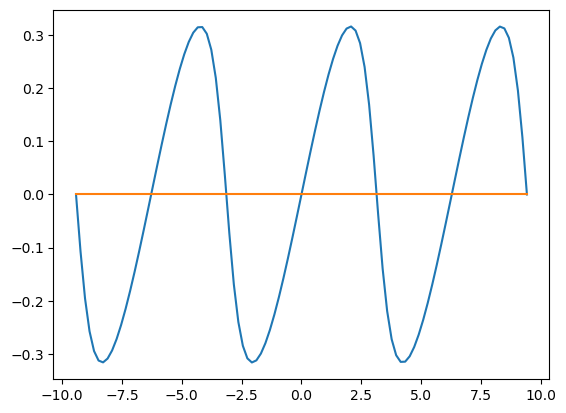

In [117]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, Va_QCD_prime(tharr)/(mpi**2 * fpi**2))
plt.plot(tharr, np.zeros_like(tharr))

del tharr

Axion mass at zero temperature: $m_a(f_a) = \sqrt{z'} \, m_\pi f_\pi / f_a$

In [118]:
def ma_QCD(fa, T=0, p=12, small=1.e-6):
    """
    ma_QCD : mass of the axion [GeV], to leading order in chPT (i.e., the first term in Eq. (19) of arXiv:1511.02867).

    Parameters:
    fa : axion decay constant [GeV]
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    ma_QCD [GeV]
    """
    
    pref = mpi**2 * fpi**2
    ma2fa2 = zp * pref
    
    return np.sqrt(ma2fa2 * FTemp(T=T, p=p, small=small) / fa**2)

In [119]:
ma_QCD(1.e12) / eV

5.7744625260303095e-06

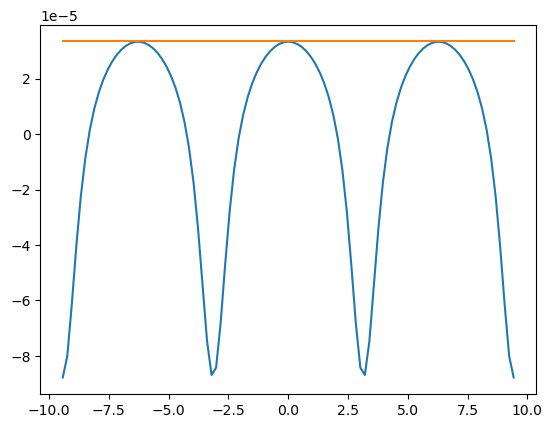

In [120]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, np.gradient(Va_QCD_prime(tharr), tharr))
plt.plot(tharr, np.ones_like(tharr)*ma_QCD(1)**2)

del tharr

## 1.3 $\mathbb{Z}_N$-axion Model

### 1.3.1 $\mathbb{Z}_N$ contribution

$\mathbb{Z}_N$ potential:

$V_N(\theta) \supset (m_a^2)_{\rm QCD} f_a^2 \, (-1)^N \frac{\epsilon_N}{N^2} \cos( N\theta )$,

with

$\epsilon_N \simeq \sqrt{\frac{1 - z^2}{\pi}} (1+z) N^{3/2} z^{N-1}$

In [121]:
def epsilon_N(N):
    """
    epsilon_N : suppression [dimless] of the QCD axion mass in the ZN-axion model.

    Parameters:
    N : number of SM copies [dimless, integer]

    Return:
    epsilon_N [dimless]
    """

    eps_N = np.sqrt((1 - zud**2)/pi) * (1 + zud) * np.power(N, 3/2) * np.power(zud, N-1)

    return eps_N

In [122]:
def Va_N(theta, N, cancel_cc=True):
    """
    Va_N : axion potential [GeV^4] in the ZN model.

    Parameters:
    theta : axion field [radians]
    N : number of SM copies [dimless, integer]
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_N [GeV^4]
    """

    ma2fa2 = zp * mpi**2 * fpi**2

    eps_N = epsilon_N(N)
    
    prefN = ma2fa2*np.power(-1, N)*eps_N / np.power(N, 2)
    oscN = np.cos(N*theta)

    v = prefN*oscN
    
    if cancel_cc == True:
        v -= prefN
    
    return v

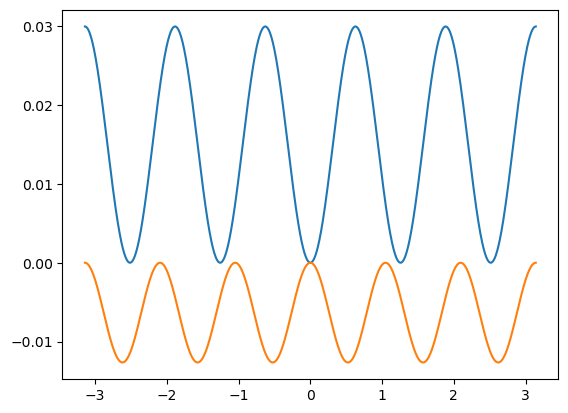

In [123]:
N1 = 5
N2 = 6

tharr = np.linspace(-pi, pi, 1001)

plt.plot(tharr, Va_N(tharr, N1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, Va_N(tharr, N2)/(zp * mpi**2 * fpi**2))

del N1, N2, tharr

Its field derivative:

$V_N'(\theta) = (m_a^2)_{\rm QCD} f_a^2 \, (-1)^{N+1} \frac{\epsilon_N}{N} \sin( N\theta )$

In [124]:
def Va_N_prime(theta, N):
    """
    Va_N_prime : field derivative of the axion potential [GeV^4] in the ZN model.

    Parameters:
    theta : axion field [radians]
    N : number of SM copies [dimless, integer]

    Returns:
    Va_N_prime [GeV^4]
    """

    ma2fa2 = zp * mpi**2 * fpi**2

    eps_N = epsilon_N(N)
    
    prefNp = ma2fa2*np.power(-1, N+1)*eps_N / N
    oscN = np.sin(N*theta)

    vp = prefNp*oscN
    
    return vp

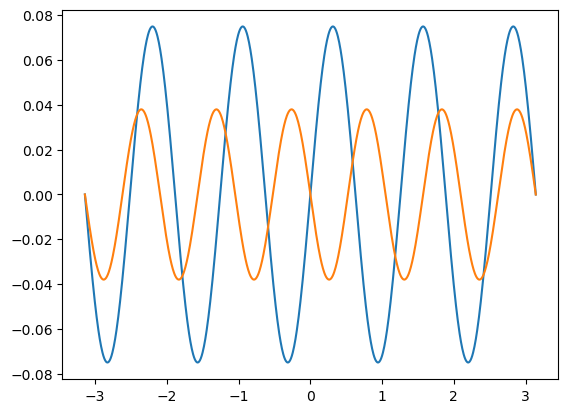

In [125]:
N1 = 5
N2 = 6

tharr = np.linspace(-pi, pi, 1001)

plt.plot(tharr, Va_N_prime(tharr, N1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, Va_N_prime(tharr, N2)/(zp * mpi**2 * fpi**2))

del N1, N2, tharr

Mass squared contribution:

$\left( m_a^2 \right)_N = (-1)^{N+1} \epsilon_N \left( m_a^2 \right)_{\rm QCD}$

In [126]:
def ma_N2(N, fa):
    """
    ma_N2 : squared axion mass [GeV^2] in the ZN model.

    Parameters:
    N : number of SM copies [dimless, integer]
    fa : axion decay constant [GeV]

    Returns:
    ma_N2 [GeV^2]
    """

    eps_N = epsilon_N(N)

    sup = np.power(-1, N+1)*eps_N

    return sup * ma_QCD(fa)**2

### 1.3.2 Reheaton contribution

Reheaton-induced potential:

$V_\phi(T, \theta) = \frac{(m_a^2)_{\rm QCD} f_a^2}{z'} \left[ 1 - (1 + \epsilon_\phi) F(T)  \right] \, \sqrt{1 + 2 z' \left( \cos(\theta) - 1 \right)} = m_\pi^2 f_\pi^2 \, \left[ 1 - (1 + \epsilon_\phi) F(T)  \right] \, \sqrt{1 + 2 z' \left( \cos(\theta) - 1 \right)}$

In [127]:
def Va_phi(theta, T, eps_phi, p=12, small=1.e-6, cancel_cc=True):
    """
    Va_phi : axion potential [GeV^4] contribution from the reheaton in the ZN model.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_phi [GeV^4]
    """
    
    pref = (mpi**2 * fpi**2)
    temp_pref = (1 - (1 + eps_phi)*FTemp(T, p=p, small=small))
    osc = chpt_fn(theta)

    v = pref*temp_pref*osc
    
    if cancel_cc == True:
        v -= -eps_phi * pref
    
    return v

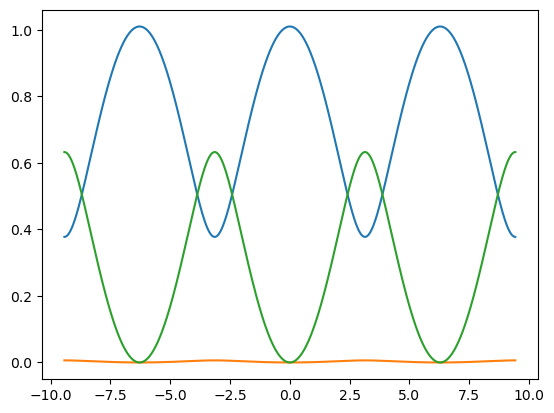

In [128]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Va_phi(tharr, T1, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi(tharr, T2, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi(tharr, T2, ephi)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, tharr

It's field derivative:

$V_\phi'(\theta) = z' m_\pi^2 f_\pi^2 \left[ 1 - (1+\epsilon_\phi) F(T) \right] \,\frac{\sin(\theta)}{\sqrt{1 + 2z'(\cos(\theta) - 1)}}$

In [129]:
def Va_phi_prime(theta, T, eps_phi, p=12, small=1.e-6):
    """
    Va_phi_prime : field derivative of the axion potential [GeV^4] contribution from the reheaton in the ZN model.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_phi_prime [GeV^4]
    """

    pref = (mpi**2 * fpi**2)
    ma2fa2 = zp*pref
    temp_pref = (1 - (1 + eps_phi)*FTemp(T, p=p, small=small))
    
    num = ma2fa2*temp_pref*np.sin(theta)
    den = chpt_fn(theta)

    return num/den

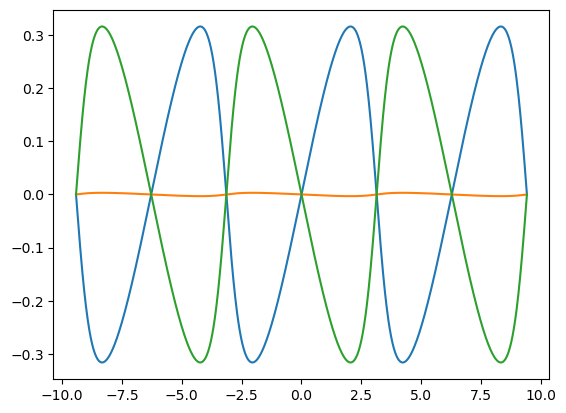

In [130]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Va_phi_prime(tharr, T1, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi_prime(tharr, T2, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi_prime(tharr, T2, ephi)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, tharr

Mass squared contribution:

$(m_a^2)_\phi = \epsilon_\phi (m_a^2)_{\rm QCD}$

In [131]:
def ma_phi2(eps_phi, fa):
    """
    ma_phi2 : axion mass squared [GeV^2] contribution from the reheaton in the ZN model.

    Parameters:
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    fa : axion decay constant [GeV]

    Returns:
    ma_phi2 [GeV^2]
    """

    return eps_phi*ma_QCD(fa)**2

At hight temperatures the minimum is $\theta = \pi$, and this is the axion mass:

$\left( m_a^2 \right)_{\pi} = \left( \frac{1+z}{1-z} \right) \, (m_a^2)_{\rm QCD}$

In [132]:
def ma_pi2(fa):

    pref = (1 + zud)/(1 - zud)

    return pref*ma_QCD(fa)**2

### 1.3.3 Total

Total axion potential:

$V_{\rm tot}(T, \theta) = V_N(\theta) + V_\phi (T, \theta)$

In [133]:
def Vtot(theta, T, model, eps_phi, N, p=12, small=1.e-6, cancel_cc=True):
    """
    Vtot : total axion potential [GeV^4], summed over all contributions.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Vtot [GeV^4]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        vtot = FTemp(T, p=p, small=small)*Va_QCD(theta)

    elif model == 'ZN':
        if N == np.inf:
            vn = 0.
        else:
            vn = Va_N(theta, N, cancel_cc=cancel_cc)

        vphi = Va_phi(theta, T, eps_phi, p=p, small=small, cancel_cc=cancel_cc)

        vtot = vn + vphi
    
    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))
    
    return vtot

epsilon_N =  0.07496392083572753
epsilon_phi =  0.01


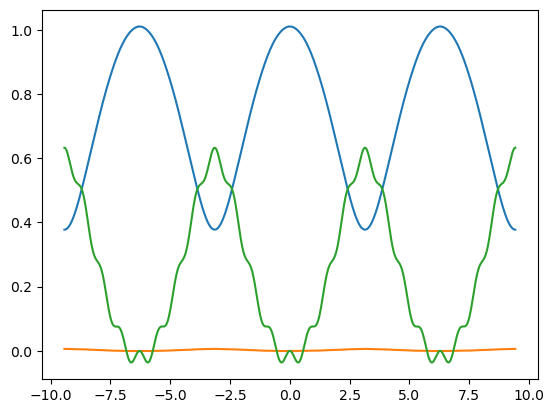

In [134]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2
eN = 8

print("epsilon_N = ", epsilon_N(eN))
print("epsilon_phi = ", ephi)

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Vtot(tharr, T1, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot(tharr, T2, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot(tharr, T2, 'ZN', ephi, eN)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, eN, tharr

and its field derivative:

In [135]:
def Vtot_prime(theta, T, model, eps_phi, N, p=12, small=1.e-6):
    """
    Vtot_prime : field derivative of the total axion potential [GeV^4], summed over all contributions.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Vtot_prime [GeV^4]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        vtotp = FTemp(T, p=p, small=small)*Va_QCD_prime(theta)
    
    elif model == 'ZN':
        if N == np.inf:
            vnp = 0.
        else:
            vnp = Va_N_prime(theta, N)

        vphip = Va_phi_prime(theta, T, eps_phi, p=p, small=small)

        vtotp = vnp + vphip

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))

    return vtotp

epsilon_N =  0.0032871285943440317
epsilon_phi =  0.01


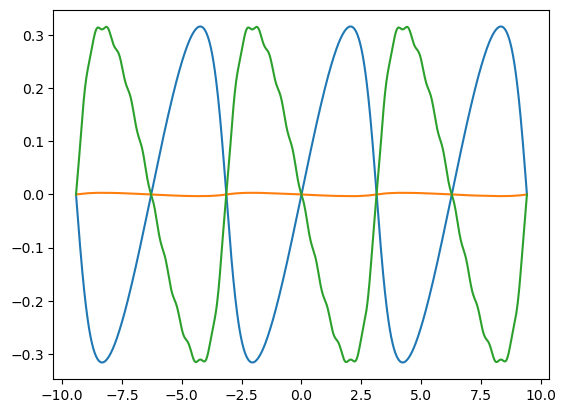

In [136]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2
eN = 13

print("epsilon_N = ", epsilon_N(eN))
print("epsilon_phi = ", ephi)

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Vtot_prime(tharr, T1, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot_prime(tharr, T2, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot_prime(tharr, T2, 'ZN', ephi, eN)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, eN, tharr

The total axion mass, in the $\mathbb{Z}_N$ model:

In [137]:
def ma_tot2(eps_phi, N, fa):
    """
    ma_tot2 : the square of the total axion mass [GeV^2] in the ZN model (w/ reheaton).

    Parameters:
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    fa : axion decay constant [GeV]

    Returns:
    ma_tot2 [GeV^2]
    """

    return ma_phi2(eps_phi, fa) + ma_N2(N, fa)

## 1.4 Time of onset of oscillations: $t_{\rm osc}$:

$3 H(t_{\rm osc}) = m_a(t_{\rm osc})$

In [138]:
def tosc(ma_fn):
    """
    tosc : time [GeV^-1] at which the axion oscillations begin.

    Parameters:
    ma_fn : axion mass [GeV] as a function of time [GeV^-1]

    Returns:
    tosc [GeV^-1]
    """

    dimless_ma_appx = tcrit*ma_fn(1)
    hubb_appx = dimless_ma_appx/3
    x_appx = 0.5/hubb_appx

    h_of_x = lambda x: tcrit*Hubt(x*tcrit) # dimless Hubble rate

    min_Lfn = lambda Lx: np.log10(3*h_of_x(10.**Lx)) - np.log10(tcrit*ma_fn(10.**Lx))

    x_osc = (10.**fsolve(min_Lfn, np.log10(x_appx)))[0]

    return x_osc*tcrit

In [139]:
ma_of_x = lambda x: ma_QCD(1.e17, T_fn(x*tcrit))

tosc(ma_of_x)

2.1732366700286312e+19

# 2. Axion Equations

**TODO**: recall that the potential depends on the temperature explicitely, and thus on time.

Furthermore, recall that I have solved for $H(t)$ in the radiation-dominated era, which may not be true if the axion has a significant energy density when oscillating around $\theta = \pi$.

Also, note that in the dimless time and dimless axion field, the field-derivative of the potentialo needs to be multiplied by $t_c^2/f_a^2$.

Define EOM for axion in terms of $m_a t$, which is more convenient too (as it appears that solving in terms of $t/t_{\rm crit}$ leads to instabilities [it is not solving the eqns!])

Define the check for oscillations as a boolean check, with an argument for canonical vs ZN axion

Define the axion_eom with an argument for canonical vs ZN axion

Define routine function from beginning to end, taking parameters as inputs, defining xini and xend, and computing omega_dm, and such

## 2.1 Interval of Integration

Defining convenient integration boundaries:

In [140]:
def find_x_interval(model, fa, eps_phi, ini_factor, end_factor):
    """
    find_x_interval : find a reasonable interval in dimless time x=t/tcrit in which to perform the integration of the axion equations of motion, centered around the oscillation time x_osc = t_osc/tcrit.

    Parameters:
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    ini_factor : ratio t_ini/t_osc
    end_factor : ratio t_end/t_osc

    Returns:
    (x_ini, x_end) [dimless]
    """

    if model == 'QCD':
        ma_of_xini = lambda x: ma_QCD(fa, T_fn(x*tcrit))
        ma_of_xend = ma_of_xini

    elif model == 'ZN':
        ma_of_xini = lambda x: np.sqrt(ma_pi2(fa))
        ma_of_xend = lambda x: np.sqrt(ma_phi2(eps_phi, fa))

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))
    
    x_ini = tosc(ma_of_xini)/tcrit
    x_end = tosc(ma_of_xend)/tcrit

    x_ini *= ini_factor
    x_end *= end_factor


    return (x_ini, x_end)

In [141]:
find_x_interval('QCD', 1.e17, 1, 0.01, 100)

(0.010249197340930702, 102.49197340930702)

In [143]:
find_x_interval('ZN', 1.e17, 1.e-5, 0.01, 100)

(0.007491498564362291, 39138.269673369345)

In [144]:
find_x_interval('other', 1.e17, 1.e-5, 51, 0.01, 100)

TypeError: find_x_interval() takes 5 positional arguments but 6 were given

Defining a "smart" array of evaluation for the solution:

In [141]:
# def smart_array(x_tuple, Nsteps=1001):

#     if len(x_tuple) == 2:
        
#         x_ini, x_end = x_tuple

#         span = np.log10(x_end/x_ini)

#         if span <= 2:
#             return np.linspace(np.log10(x_ini), np.log10(x_end), max(Nsteps, int(np.round(span*10))))
        
#         else:
#             return np.logspace(np.log10(x_ini), np.log10(x_end), Nsteps)

#     elif len(x_tuple) == 3:

#         x_ini, x_osc, x_end = x_tuple

#         span1 = np.log10(x_osc / x_ini)
#         span2 = np.log10(x_end / x_osc)

#         first_array = 
#         second_array = 
#         third_array = 

#     elif len(x_tuple) == 4:


## 2.2 Axion EOM

$\ddot{\theta} + 3 H \dot{\theta} + V'(\theta, T) = 0$

In [147]:
def axion_eom(x, Y, model, fa, eps_phi, N, p=12, small=1.e-6):
    """
    axion_eom : equations of motion of the axion field. Converts the originally nonlinear second-order ODE into a system of two first-order ODEs.

    Parameters:
    x : dimensionless time t/tcrit - independent variable [dimless]
    Y : axion angle and its time derivative - dependent variables [y, y'] = [theta, theta'] ][radians, radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    [y', y''] = [theta', theta''] [dimless, dimless]
    """

    y, dy = Y # breaking down the tuplet

    temp = T_fn(x*tcrit) # temperature [GeV]
    h = tcrit*Hubt(x*tcrit) # dimless Hubble rate

    dimfac = (tcrit/fa)**2 # prefactor to turn potential into dimless quantity
    vp = dimfac*Vtot_prime(y, temp, model, eps_phi, N, p=p, small=small) # field derivative of the potential [dimless]

    ddy = -3*h*dy - vp

    return [dy, ddy]

## 2.3 Solving the axion EOM

In [ ]:
def solve_axion_eom(model, fa, eps_phi, N, y0, dy0, x_interval, p=12, small=1.e-6, method='Radau', **kwargs):
    """
    solve_axion_eom : solves the axion equations of motion with given initial conditions.

    Parameters:
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    y0 : initial condition for axion angle, theta [radians]
    dy0 : initial condition for dimless time derivative of axion angle, theta' [radians]
    x_interval : tuple - integration interval (x_ini, x_end) of dimensionless time [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    method : integration method (default: 'BDF')

    Returns:
    solution object
    """

    sol = solve_ivp(axion_eom, x_interval, [y0, dy0], args=(model, fa, eps_phi, N, p, small), method=method, **kwargs)

    return sol

## 2.4 Axion energy density

In [220]:
def axion_density(x, Y, model, fa, eps_phi, N, p=12, small=1.e-6):
    """
    axion_density : axion energy density [GeV^4].

    Parameters:
    x : dimensionless time t/tcrit - independent variable [dimless]
    Y : axion angle and its time derivative - dependent variables [y, y'] = [theta, theta'] ][radians, radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    
    Returns:
    axion_density [GeV^4]
    """

    theta, dtheta = Y
    temp = Tcrit*T_hat_fn(x)

    ke = 0.5 * dtheta**2 * (fa/tcrit)**2
    pe = Vtot(theta, temp, model, eps_phi, N, p=p, small=small, cancel_cc=True)

    en = ke + pe

    return en

In [ ]:
def axion_abundance(rho_Arr, x_Arr, xosc, x_interval):
    """
    axion_abundance : calculate the axion abundance [dimless] today, Omega_a*h^2
    
    Parameters:
    rho_Arr : array of axion energy density values [GeV^4]
    t_Arr : array of times [GeV^-1]
    
    Returns:
    axion_abundance [dimless]
    """

    a_Arr = scale_factor(x_Arr*tcrit)

    rhoa3 = rho_Arr * np.power(a_Arr, 3)

    omega_a = 

    return omega_a

## 2.5 Testing

Defining the parameters:

In [217]:
fa_test = (1.e16)*GeV # axion decay constant
epsphi_test = 1.e-6 # suppression in axion mass squared
N_test = 51 # number of SM copies

Initial conditions:

In [218]:
theta_ini, dtheta_ini = 1, 0

### 2.5.1 QCD axion

Integration interval

In [ ]:
x_osc = find_x_interval('QCD', fa_test, epsphi_test, 1, 1)[0] # dimless oscillation time for QCD
x_span = find_x_interval('QCD', fa_test, epsphi_test, 0.01, 100) # dimless integration interval for QCD

print("QCD: x_osc={:g}".format(x_osc))
print("QCD: x_span=({:g}, {:g})".format(x_span[0], x_span[1]))

QCD: x_osc=0.494626
QCD: x_span=(0.00494626, 49.4626)


Solving the EOM

In [207]:
# solve_axion_eom(model, fa, eps_phi, N, y0, dy0, x_span, p=12, small=1.e-6, method='BDF', **kwargs)

In [208]:
%time
sol1 = solve_axion_eom('QCD', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, 8, 1.e-6, method='BDF', atol=1.e-5, rtol=1.e-4) # solving QCD axion EOM w/ BDF method

%time
sol2 = solve_axion_eom('QCD', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, 8, 1.e-6, method='Radau', atol=1.e-5, rtol=1.e-4) # solving QCD axion EOM w/ Radau method

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [209]:
print(len(sol1.t))
print(len(sol2.t))
print((sol2.y).shape)

2468
1505
(2, 1505)


Important results:

In [210]:
# resulting temperature arrays
temp_arr1 = Tcrit*T_hat_fn(sol1.t)
temp_arr2 = Tcrit*T_hat_fn(sol2.t)

# energy density
rho_arr1 = (tcrit/fa_test)**2 * axion_density(sol1.t, (sol1.y[0], sol1.y[1]), 'QCD', fa_test, 1, 1)
rho_arr2 = (tcrit/fa_test)**2 * axion_density(sol2.t, (sol2.y[0], sol2.y[1]), 'QCD', fa_test, 1, 1)

# scale factor
a_arr1 = scale_factor(sol1.t*tcrit)
a_arr2 = scale_factor(sol2.t*tcrit)

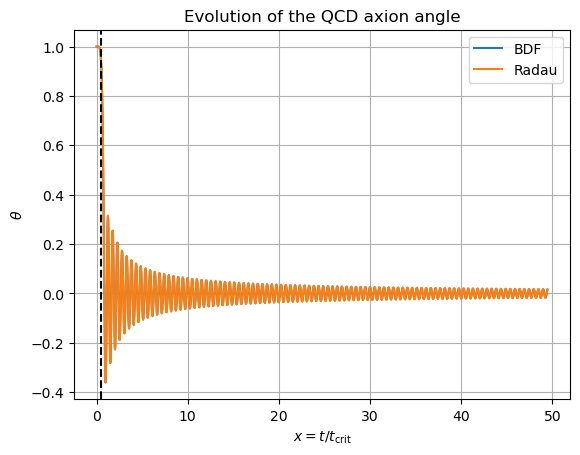

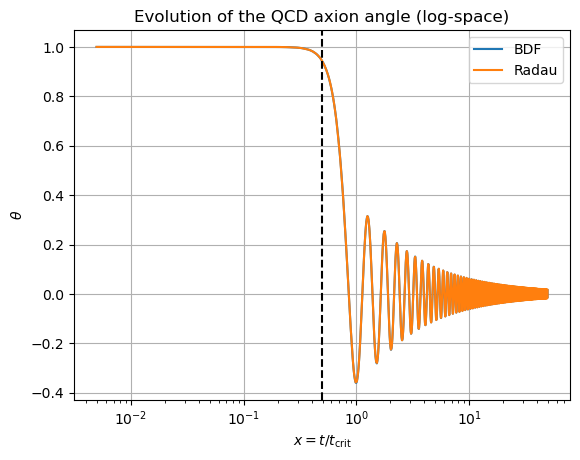

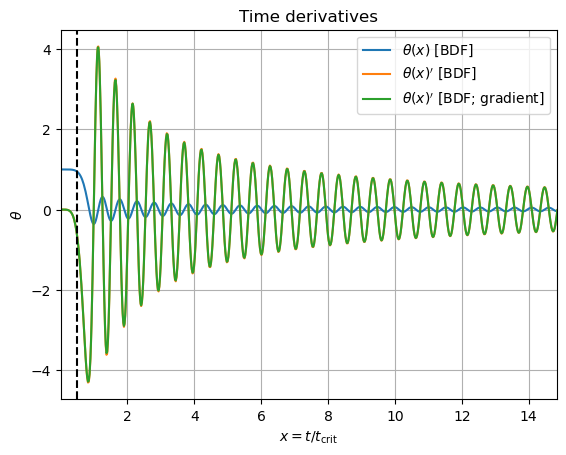

In [211]:
# Plot the result
plt.plot(sol1.t, sol1.y[0], label=r"BDF")
plt.plot(sol2.t, sol2.y[0], label=r"Radau")
plt.xlabel(r"$x = t/t_{\rm crit}$")
plt.ylabel(r"$\theta$")
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Evolution of the QCD axion angle")
plt.legend()
plt.grid()
plt.show()

# in log-space
plt.plot(sol1.t, sol1.y[0], label=r"BDF")
plt.plot(sol2.t, sol2.y[0], label=r"Radau")
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.ylabel(r"$\theta$")
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Evolution of the QCD axion angle (log-space)")
plt.legend()
plt.grid()
plt.show()

# derivatives
plt.plot(sol1.t, sol1.y[0], label=r"$\theta(x)$ [BDF]")
plt.plot(sol1.t, sol1.y[1], label=r"$\theta(x)'$ [BDF]")
plt.plot(sol1.t, np.gradient(sol1.y[0], sol1.t), label=r"$\theta(x)'$ [BDF; gradient]")
plt.xlim(x_span[0], 30*x_osc)
plt.xlabel(r"$x = t/t_{\rm crit}$")
plt.ylabel(r"$\theta$")
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Time derivatives")
plt.legend()
plt.grid()
plt.show()

Finding out scaling with scale factor; comparing both methods:

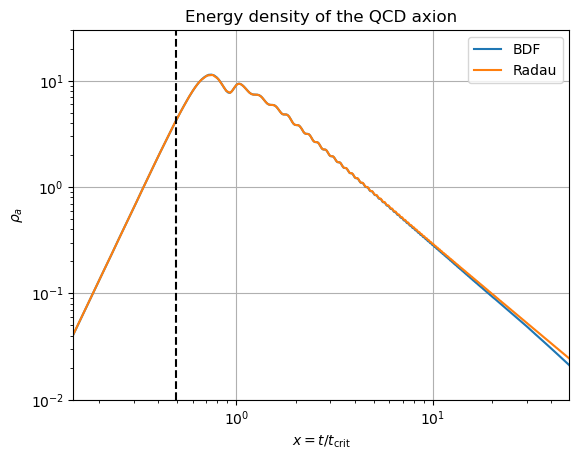

In [215]:
plt.plot(sol1.t, rho_arr1, label=r"BDF")
plt.plot(sol2.t, rho_arr2, label=r"Radau")
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.xlim(x_osc*0.3, x_span[-1])
plt.ylabel(r"$\rho_a$"), plt.yscale('log')
plt.ylim(1.e-2, 30)
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()

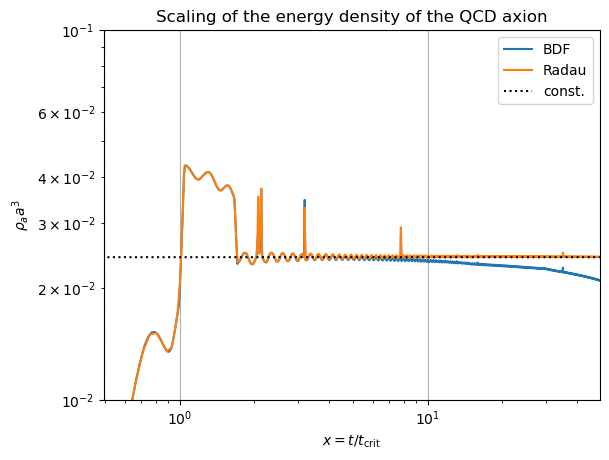

In [216]:
overall_scale1 = rho_arr1[-1]/(a_arr1[-1]**(-3))
overall_scale2 = rho_arr2[-1]/(a_arr2[-1]**(-3))

plt.plot(sol1.t, rho_arr1*(a_arr1/a_arr1[-1])**3, label=r"BDF")
plt.plot(sol2.t, rho_arr2*(a_arr2/a_arr2[-1])**3, label=r"Radau")
plt.plot(sol2.t, np.ones_like(sol2.t)*rho_arr2[-1], label=r"const.", ls=':', color='k')
plt.xlabel(r"$x = t/t_{\rm crit}$"), plt.xscale('log')
plt.xlim(x_osc, x_span[-1])
plt.ylabel(r"$\rho_a a^3$"), plt.yscale('log')
plt.ylim(1.e-2, 0.1)
plt.axvline(x=x_osc, color='k', ls='--')
plt.title("Scaling of the energy density of the QCD axion")
plt.legend()
plt.grid()
plt.show()

del overall_scale1, overall_scale2

Clearing definitions

In [ ]:
# del fa_test, epsphi_test, N_test, x_osc, x_span, theta_ini, dtheta_ini, sol1, sol2, temp_arr1, temp_arr2, rho_arr1, rho_arr2, a_arr1, a_arr2

### 2.5.2 $\mathbb{Z}_N$-axion

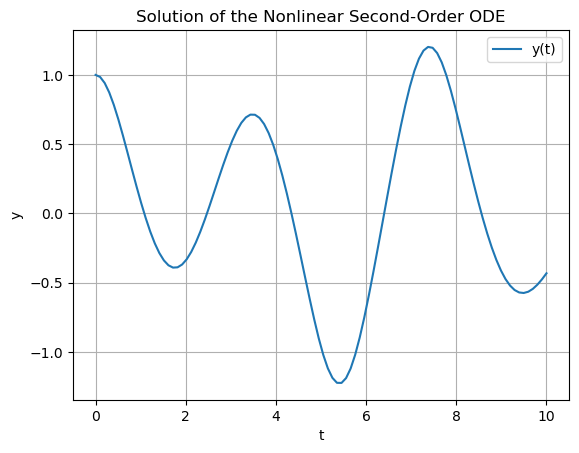

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import solve_ivp

def second_order_nonlinear_ode(t, Y, p, q, r, f):
    """
    Converts a nonlinear second-order ODE into a system of first-order ODEs.

    Parameters:
    t  - Independent variable
    Y  - Dependent variables [y, y']
    p, q, r, f - Functions defining the ODE

    Returns:
    [y', y'']
    """
    y, dy = Y
    ddy = -p(t) * dy - q(t) * y - f(y) + r(t)
    return [dy, ddy]



# Example: Define the ODE parameters
p = lambda t: 0.1       # Damping coefficient
q = lambda t: 2.0       # Stiffness coefficient
r = lambda t: np.sin(t) # External forcing function
f = lambda y: y**3      # Nonlinear term (e.g., Duffing oscillator)

# Initial conditions
y0 = 1.0
dy0 = 0.0
t_span = (0, 10)
t_eval = np.linspace(*t_span, 100)

# Solve the ODE
solution = solve_nonlinear_ode(p, q, r, f, y0, dy0, t_span, t_eval)

# Plot the result
plt.plot(solution.t, solution.y[0], label="y(t)")
plt.xlabel("t")
plt.ylabel("y")
plt.title("Solution of the Nonlinear Second-Order ODE")
plt.legend()
plt.grid()
plt.show()

del p, q, r, f, y0, dy0, t_span, t_eval, solution, second_order_nonlinear_ode, solve_nonlinear_ode